In [31]:
import pprint

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient

from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [32]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
col = db["india"]

In [33]:
col.find_one()

{'_id': ObjectId('67f54f743fc4bf1cdcc605cf'),
 'City': 'Ahmedabad',
 'Datetime': '1/1/2015 1:00',
 'PM2': '',
 'PM10': '',
 'NO': '1',
 'NO2': '40.01',
 'NOx': '36.37',
 'NH3': '',
 'CO': '1',
 'SO2': '122.07',
 'O3': '',
 'Benzene': '0',
 'Toluene': '0',
 'Xylene': '0',
 'AQI': '',
 'AQI_Bucket': ''}

In [34]:
def wrangle(collection):
    results = collection.find({
        "City": "Mumbai"
    }, projection = {
        "Datetime": 1, "PM2": 1, "_id": 0
    })
    
    df = pd.DataFrame(results).set_index("Datetime")
    
    # Filter to only data from 2020
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.year.isin(range(2015, 2020))]
    
    # Filter to Mumbai tz
    df.index = df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
    
    # Convert PM2 to floating point number
    df["PM2"] = df["PM2"].astype(float)
    
    # Remove outliers
    df = df[df["PM2"] < 140]
    
    # Drop all null values
    df.dropna(inplace=True)
    

    return df

In [35]:
df = wrangle(col)
df.head()

,PM2
Datetime,
2020-01-01 05:30:00+05:30,80.90
2020-01-01 06:30:00+05:30,88.78
2020-01-01 07:30:00+05:30,117.02
2020-01-01 08:30:00+05:30,127.49
2020-01-01 09:30:00+05:30,131.77


In [100]:
y = df["PM2"].resample("1H").mean().fillna(method="ffill")
y.head()

Datetime
2020-01-01 05:00:00+05:30     80.90
2020-01-01 06:00:00+05:30     88.78
2020-01-01 07:00:00+05:30    117.02
2020-01-01 08:00:00+05:30    127.49
2020-01-01 09:00:00+05:30    131.77
Freq: H, Name: PM2, dtype: float64

In [101]:
y.corr(y.shift(6))

0.7940007645263903

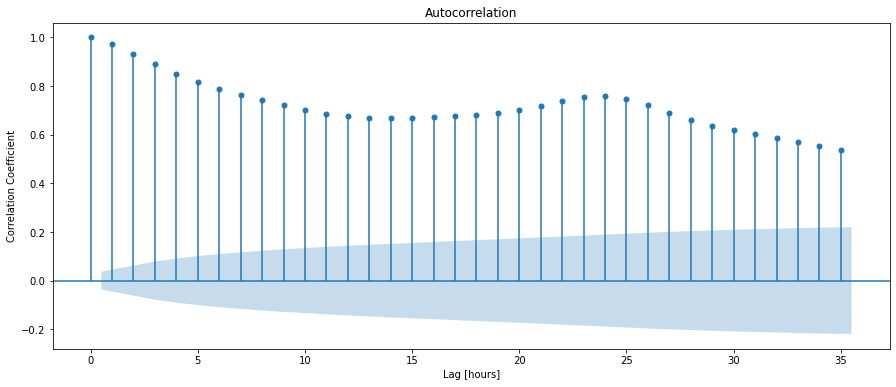

In [102]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

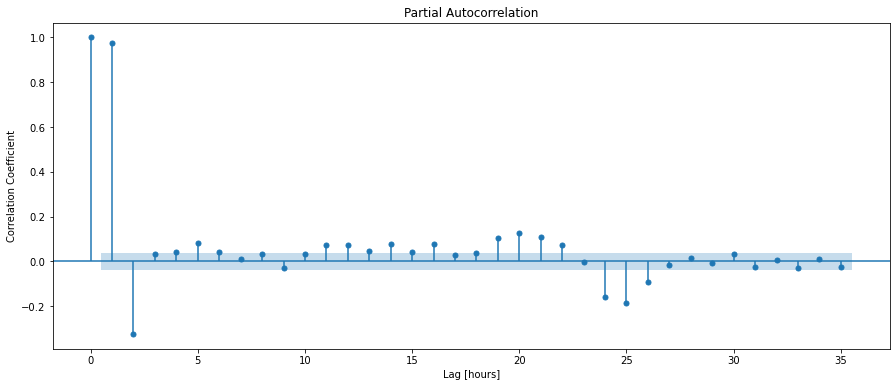

In [103]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [104]:
# train test split
cutoff = int(len(y) * 0.8)
y_train = y[:cutoff]
y_test = y[cutoff:]

In [105]:
# calculate baseline mae
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mae(y_train, y_pred_baseline)
baseline_mae

25.338010670663973

In [115]:
model = AutoReg(y_train, lags=26).fit()

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [116]:
#make prediction using the walk forward validation model
y_pred_train = model.predict().dropna()

In [118]:
#Calculate training mean absolute error
training_mae = mae(y_train[26:], y_pred_train)
training_mae

4.356588174707222

In [63]:
# Predict with test data

Datetime
2020-01-02 09:30:00+05:30   NaN
2020-01-02 10:30:00+05:30   NaN
2020-01-02 11:30:00+05:30   NaN
2020-01-02 12:30:00+05:30   NaN
2020-01-02 13:30:00+05:30   NaN
                             ..
2020-04-06 21:30:00+05:30   NaN
2020-04-06 22:30:00+05:30   NaN
2020-04-06 23:30:00+05:30   NaN
2020-04-07 00:30:00+05:30   NaN
2020-04-07 01:30:00+05:30   NaN
Length: 2292, dtype: float64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2898 entries, 2020-01-01 05:30:00+05:30 to 2020-05-01 05:30:00+05:30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2     2898 non-null   float64
dtypes: float64(1)
memory usage: 45.3 KB


In [73]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    PM2   No. Observations:                 2318
Model:                     AutoReg(1)   Log Likelihood               -7840.740
Method:               Conditional MLE   S.D. of innovations              7.135
Date:                Sat, 12 Apr 2025   AIC                              3.933
Time:                        19:07:30   BIC                              3.940
Sample:                             1   HQIC                             3.935
                                 2318                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5497      0.310      4.992      0.000       0.941       2.158
PM2.L1         0.9713      0.005    196.004      0.000       0.962       0.981
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0295           +0.0000j            1.0295            0.0000
-----------------------------------------------------------------------------
"""